In [1]:
import os

In [2]:
computation = 'cloud'

In [3]:
if computation == 'cloud' :
  from google.colab import drive
  drive.mount('/content/drive')
  data_path = '/content/drive/MyDrive/uco_fraud_detector/data/transaction_fraud'
  data_preprocess_path = '/content/drive/MyDrive/uco_fraud_detector/data/data_preprocess'
  seq_data_path = '/content/drive/MyDrive/uco_fraud_detector/data/recent_seq_data_n100_valid_only'
  global_model_path = '/content/drive/MyDrive/uco_fraud_detector/models/globalmodel_1'
  recent_transformer_path = '/content/drive/MyDrive/uco_fraud_detector/models/best_2block_transformer_n100_model_1.keras'
  ensemble_model_path = '/content/drive/MyDrive/uco_fraud_detector/models/recent_ensemble_model'
else :
  data_path = '../data/transaction_fraud'
  data_preprocess_path = '../data/data_preprocess'
  seq_data_path = '../data/recent_seq_data_n100_valid_only'
  global_model_path = '../models/globalmodel_1'
  recent_transformer_path = '../models/best_2block_transformer_n100_model_1.keras'
  ensemble_model_path = '../models/recent_ensemble_model'

print("searching for data path" , "found" if os.path.exists(data_path) else "not found")
print(os.listdir(data_path))

Mounted at /content/drive
searching for data path found
['bs140513_032310.csv', 'bsNET140513_032310.csv']


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import classification_report , confusion_matrix , roc_curve , auc , precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import time

### ___

In [5]:
@tf.keras.utils.register_keras_serializable()
class ExpandDims(layers.Layer):
    def __init__(self, **kwargs):
        super(ExpandDims, self).__init__(**kwargs)
    def call(self, inputs):
        return tf.expand_dims(inputs, axis=-1)
    def get_config(self):
        config = super(ExpandDims, self).get_config()
        return config
    @classmethod
    def from_config(cls, config):
        return cls(**config)

@tf.keras.utils.register_keras_serializable()
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.2, name='multi_head_attention')
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4), name='dense_1'),
            layers.Dense(embed_dim, kernel_regularizer=keras.regularizers.l2(1e-4), name='dense_2')
        ], name='feed_forward_network')
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6, name='layer_norm_1')
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6, name='layer_norm_2')
        self.dropout1 = layers.Dropout(rate, name='dropout_1')
        self.dropout2 = layers.Dropout(rate, name='dropout_2')

    def call(self, inputs, training, mask=None):
        # Assuming inputs is the combined tensor after embedding and concatenation
        seq_len = tf.shape(inputs)[1]
        causal_mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        causal_mask = tf.cast(causal_mask, tf.bool)

        # Get the mask from the input tensor (assuming masking was applied before)
        input_mask = self._compute_mask(inputs, mask=mask)
        if input_mask is not None:
            # Expand mask to be compatible with attention mask shape
            input_mask = tf.cast(input_mask, causal_mask.dtype)
            causal_mask = causal_mask & input_mask[:, tf.newaxis, :]

        norm1 = self.layernorm1(inputs)
        attn_output = self.att(norm1, norm1, attention_mask=causal_mask)
        current_transaction_bias = tf.zeros_like(attn_output)
        current_transaction_bias = current_transaction_bias[:, 0:1, :] + 0.1
        attn_output = attn_output + current_transaction_bias
        attn_output = self.dropout1(attn_output, training=training)
        out1 = inputs + attn_output
        norm2 = self.layernorm2(out1)
        ffn_output = self.ffn(norm2)
        ffn_output = self.dropout2(ffn_output, training=training)
        return out1 + ffn_output

    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate
        })
        return config

    def _compute_mask(self, inputs, mask=None):
        # Compute mask based on the input tensor's mask if available
        return tf.keras.backend.get_value(inputs._keras_mask) if hasattr(inputs, '_keras_mask') else None

### ___

In [6]:
f = open(global_model_path , 'rb')
global_model = pickle.load(f)
f.close()

f = open(seq_data_path , 'rb')
seq_data = pickle.load(f)
f.close()

f = open(ensemble_model_path , 'rb')
ensemble_model = pickle.load(f)
f.close()

transformer = keras.models.load_model(recent_transformer_path)

f = open(data_preprocess_path , 'rb')
data_preprocess = pickle.load(f)
f.close()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_block_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_block_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [7]:
print(" feature inputsd to global model : ",global_model.feature_names_in_)
print("feature input to transformer : ")
print("NUMERICAL COLS : " , data_preprocess['NUMERICAL_COLS'])
print("CATEGORICAL COLS : " , data_preprocess['CATEGORICAL_COLS'])
print("ensemble_model feature inputs : ")
print(ensemble_model.feature_names_in_)

 feature inputsd to global model :  ['time_delta' 'age' 'gender' 'merchant_id' 'category' 'amount'
 'account_frequency' 'merchant_frequency']
feature input to transformer : 
NUMERICAL COLS :  ['time_delta', 'account_frequency', 'merchant_frequency', 'amount']
CATEGORICAL COLS :  ['age', 'gender', 'merchant_id', 'category']
ensemble_model feature inputs : 
['age' 'gender' 'category' 'amount' 'recent_transformer_fraud'
 'global_model_fraud']


In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
sequences = seq_data['sequences']
targets = seq_data['targets']

In [10]:
def handleLog(transaction_sequence,
              global_output_proba,
              transformer_output_proba,
              ensemble_output) :
  current_transaction = transaction_sequence[0]
  print("the current transaction is : ")
  print(current_transaction)
  print("the global model output is : " , global_output_proba)
  print("the transformer output is : " , transformer_output_proba)
  print("the ensemble model output is : " , ensemble_output)
  single_sequence = np.array(transaction_sequence)
  pca = PCA(n_components=3) # dim reduction
  reduced_data = pca.fit_transform(single_sequence)
  x = reduced_data[:, 0]
  y = reduced_data[:, 1]
  z = reduced_data[:, 2]
  fig = plt.figure(figsize=(7, 5))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[1:], y[1:], z[1:], c='blue', label='Historical Transactions', alpha=0.6)
  ax.scatter(x[0], y[0], z[0], c='red', s=100, label='Current Transaction', edgecolor='black')
  ax.set_xlabel('PCA 1')
  ax.set_ylabel('PCA 2')
  ax.set_zlabel('PCA 3')
  ax.set_title('Sequence Data')
  ax.legend()
  plt.show()
  #


def check_transaction(transaction_sequence ,
                      data_preprocess,
                      global_model ,
                      transformer ,
                      ensemble_model,
                      get_proba = False,
                      get_log = False) :
  start_time = time.time()
  current_transaction = transaction_sequence[0]
  reorganized_indices = [0, 4, 5, 6, 7, 3, 1, 2]
  reorganized_transaction = current_transaction[reorganized_indices]
  global_output_proba = global_model.predict_proba([reorganized_transaction])[0][1]
  num_numerical = len(data_preprocess['NUMERICAL_COLS'])
  single_num_seq = transaction_sequence[:, :num_numerical]
  single_cat_seq = transaction_sequence[:, num_numerical:].astype(np.int32)
  single_inputs = {
      'numerical_input': single_num_seq[np.newaxis, :, :],
      'age_input': single_cat_seq[:, 0][np.newaxis, :],
      'gender_input': single_cat_seq[:, 1][np.newaxis, :],
      'merchant_input': single_cat_seq[:, 2][np.newaxis, :],
      'category_input': single_cat_seq[:, 3][np.newaxis, :],
  }
  prediction = transformer.predict(single_inputs , verbose = 0)
  transformer_output_proba = prediction[0][0]
  ensemble_data = np.array([reorganized_transaction[1],
                            reorganized_transaction[2],
                            reorganized_transaction[4],
                            reorganized_transaction[5],
                            transformer_output_proba,
                            global_output_proba])
  if get_proba :
    ensemble_output = ensemble_model.predict_proba(ensemble_data.reshape(1 , -1))[0][1]
  else :
    ensemble_output = ensemble_model.predict(ensemble_data.reshape(1 , -1))[0]
  end_time = time.time()
  inference_time = end_time - start_time
  if get_log :
    print("inference time : " , inference_time)
  if get_log :
    handleLog(transaction_sequence , global_output_proba , transformer_output_proba , ensemble_output)

  return ensemble_output

inference time :  0.23340225219726562
the current transaction is : 
[-1.2925012   0.55031514  0.7652456   0.3260231   4.          1.
 18.         12.        ]
the global model output is :  1.5782401e-06
the transformer output is :  1.1924019e-12
the ensemble model output is :  0.00025823087


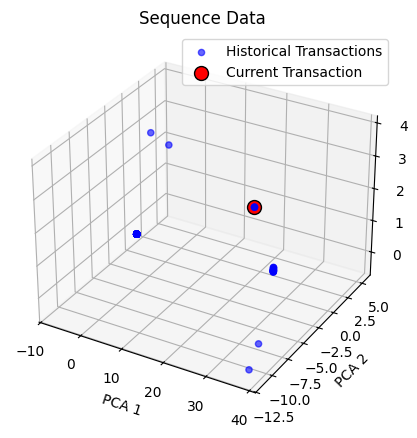

PREDICTED :  0.00025823087
True VALUE :  0 




In [12]:
i = 123432
pred = check_transaction(sequences[i] ,
                  data_preprocess,
                  global_model ,
                  transformer ,
                  ensemble_model,
                  get_proba = True,
                  get_log = True)
print("PREDICTED : " , pred)
print("True VALUE : " , targets[i] , "\n\n")

In [ ]:
# true_positive_indices = []
# tp_len = 0
# false_positive_indices = []
# fp_len = 0
# false_negative_indices = []
# fn_len = 0
# i = 0
# while i in range(sequences.shape[0]) :
#   pred = check_transaction(sequences[i] ,
#                   data_preprocess,
#                   global_model ,
#                   transformer ,
#                   ensemble_model,
#                   get_proba = False,
#                   get_log = False)
#   if pred == 1 and targets[i] == 1 :
#     true_positive_indices.append(i)
#     tp_len += 1
#   if pred == 1 and targets[i] == 0 :
#     false_positive_indices.append(i)
#     fp_len += 1
#   if pred == 0 and targets[i] == 1 :
#     false_negative_indices.append(i)
#     fn_len += 1

#   if tp_len >= 100 and fp_len >= 100 and fn_len >= 100 :
#     break
#   i += 1

In [ ]:
print("false positive indices : " , false_positive_indices)
print("\n\nfalse negative indices : " , false_negative_indices)

false positive indices :  [140, 142, 521, 1947, 3243, 5368, 5708, 10011, 12253, 12595, 14081, 14112, 15898, 15899, 18181, 21216, 21217, 24615, 24906, 25280, 25640, 25651, 25830, 27081, 27085, 30327, 30328, 34544, 34556, 35096, 36464, 36691, 38802, 41166, 42776, 42918, 44109, 47397]


false negative indices :  [145, 340, 352, 361, 3246, 3389, 6632, 6705, 8912, 10006, 11084, 11093, 11168, 12390, 12953, 14080, 14118, 14507, 17314, 17318, 17323, 17363, 17483, 18043, 21134, 21406, 23731, 24602, 24610, 24647, 24909, 25646, 27082, 33534, 33822, 34497, 34553, 36803, 39697, 45621, 45766, 46145, 46147, 47655, 48651]


false positive indices :  [140, 142, 521, 1947, 3243, 5368, 5708, 10011, 12253, 12595, 14081, 14112, 15898, 15899, 18181, 21216, 21217, 24615, 24906, 25280, 25640, 25651, 25830, 27081, 27085, 30327, 30328, 34544, 34556, 35096, 36464, 36691, 38802, 41166, 42776, 42918, 44109, 47397]


false negative indices :  [145, 340, 352, 361, 3246, 3389, 6632, 6705, 8912, 10006, 11084, 11093, 11168, 12390, 12953, 14080, 14118, 14507, 17314, 17318, 17323, 17363, 17483, 18043, 21134, 21406, 23731, 24602, 24610, 24647, 24909, 25646, 27082, 33534, 33822, 34497, 34553, 36803, 39697, 45621, 45766, 46145, 46147, 47655, 48651]

In [ ]:
for i in range(len(false_positive_indices)) :
  pred = check_transaction(sequences[false_positive_indices[i]] ,
                  data_preprocess,
                  global_model ,
                  transformer ,
                  ensemble_model,
                  get_proba = True,
                  get_log = True)
  print("PREDICTED : " , pred)
  print("True VALUE : " , targets[i] , "\n\n")